# ADS 509 Sentiment Assignment

This notebook holds the Sentiment Assignment for Module 6 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In a previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we apply sentiment analysis to those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [2]:
import os
import re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from string import punctuation

from nltk.corpus import stopwords

sw = stopwords.words("english")

In [3]:
# Add any additional import statements you need here
import string
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# change `data_location` to the location of the folder on your machine.
data_location = "/Users/lamnguyen/Dropbox/Uyen bom/USD/ADS-509/mod1/ads509_mode1_api_scrape/"

# These subfolders should still work if you correctly stored the 
# data from the Module 1 assignment
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

artist_files = {'cher':'cher_followers_data.txt',
                'robyn':'robynkonichiwa_followers_data.txt'}


positive_words_file = "positive-words.txt"
negative_words_file = "negative-words.txt"
tidy_text_file = "tidytext_sentiments.txt"

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A Pandas data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [5]:
# Read in the lyrics data

#Create list of lyric data 
lyrics_data = []

# Set path to the artist folders
for artist_folder in os.listdir(data_location + lyrics_folder):
    artist_path = os.path.join(data_location + lyrics_folder, artist_folder)
    
    # set path to the lyric file
    for lyric_file in os.listdir(artist_path):
        lyric_path = os.path.join(artist_path, lyric_file)
            
        # Read the lyrics from the lyric files
        with open(lyric_path, 'r', encoding='utf8') as infile:
            lyrics = infile.read()

        # Extract the title from the lyrics
        title = lyrics.split("\n", 1)[0].strip()

        # Remove the title from the lyrics
        lyrics = lyrics.replace(title, "").strip()

        # Append the artist, title, and lyrics to the data list
        lyrics_data.append([artist_folder, title, lyrics])

# Create a DataFrame from the lyrics data
lyrics_data = pd.DataFrame(lyrics_data, columns=['artist', 'title', 'lyrics'])
lyrics_data.head()

,artist,title,lyrics
0,robyn,"""Include Me Out""","It is really very simple\nJust a single pulse,..."
1,robyn,"""Electric""",Electric...\n\nIt's electric\nIt's a natural h...
2,robyn,"""Beach 2K20""",(So you wanna go out?\nHow you gonna get there...
3,robyn,"""Love Kills""",If you're looking for love\nGet a heart made o...
4,robyn,"""Time Machine""","Hey, what did I do?\nCan't believe the fit I j..."


In [6]:
# Read in the twitter data
twitter_data = pd.read_csv(data_location + twitter_folder + 
                           artist_files['cher'],
                           sep="\t",
                           quoting=3)

twitter_data['artist'] = "cher"

twitter_data_2 = pd.read_csv(data_location + twitter_folder + 
                             artist_files['robyn'],
                             sep="\t",
                             quoting=3)
twitter_data_2['artist'] = "robyn"

twitter_data = pd.concat([
    twitter_data,twitter_data_2])
    
del(twitter_data_2)

twitter_data.head()

,screen_name,name,id,location,followers_count,friends_count,description,artist
0,hsmcnp,Country Girl,35152213,NaN,1302,1014,NaN,cher
1,horrormomy,Jeny,742153090850164742,Earth,81,514,𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜,cher
2,anju79990584,anju,1496463006451974150,NaN,13,140,163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡,cher
3,gallionjenna,J,3366479914,NaN,752,556,csu,cher
4,bcscomm,bcscomm,83915043,"Washington, DC",888,2891,Writer @Washinformer @SpelmanCollege alumna #D...,cher


In [7]:
# Read in the positive and negative words and the
# tidytext sentiment. Store these so that the positive
# words are associated with a score of +1 and negative words
# are associated with a score of -1. You can use a dataframe or a 
# dictionary for this.

# Read positive words and assign score of +1
with open(positive_words_file, 'r') as f:
    positive_words = [line.strip() for line in f if not line.startswith(";")]
    positive_df = pd.DataFrame({'word': positive_words, 'score': 1})
    

# Read negative words and assign score of -1
with open(negative_words_file, 'r') as f:
    negative_words = [line.strip() for line in f if not line.startswith(";")]
    negative_df = pd.DataFrame({'word': negative_words, 'score': -1})
    

# Read tidytext sentiment and assign scores
with open(tidy_text_file, 'r') as f:
    lines = f.readlines()[1:]  # Skip the header row
    tidytext_df = pd.DataFrame([line.strip().split('\t') for 
                                line in lines], 
                               columns=['word', 'sentiment', 'lexicon'])
    tidytext_df = tidytext_df[tidytext_df['sentiment'].isin(['positive', 
                                                             'negative'])]  
    tidytext_df['score'] = tidytext_df['sentiment'].apply(lambda x: 1 if 
                                                          x == 'positive' else -1)

# Combine the lexicons and drop duplicates
combined_lexicon = pd.concat([positive_df, negative_df, 
        tidytext_df[['word', 'score']]]).drop_duplicates().reset_index(drop=True)

# Print the word scores DataFrame
print(combined_lexicon.head())

        word  score
0                 1
1         a+      1
2     abound      1
3    abounds      1
4  abundance      1


## Sentiment Analysis on Songs

In this section, score the sentiment for all the songs for both artists in your data set. Score the sentiment by manually calculating the sentiment using the combined lexicons provided in this repository. 

After you have calculated these sentiments, answer the questions at the end of this section.


In [8]:
#Some punctuation variations
punctuation = set(string.punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

# Stopwords
sw = stopwords.words("english")

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# It's handy to have a full set of emojis
all_language_emojis = set()

for country in emoji.EMOJI_DATA : 
    for em in emoji.EMOJI_DATA[country] : 
        all_language_emojis.add(em)

# and now our functions
def descriptive_stats(tokens, num_tokens=5, verbose=True):
    """
    Given a list of tokens, print the number of tokens, number of unique tokens,
    number of characters, lexical diversity, and num_tokens most common tokens.
    Return a list of the num_tokens most common tokens.
    """
    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    num_characters = sum(len(token) for token in tokens)
    lexical_diversity = num_unique_tokens / num_tokens

    if verbose:
        print("Number of tokens:", num_tokens)
        print("Number of unique tokens:", num_unique_tokens)
        print("Number of characters:", num_characters)
        print("Lexical diversity:", lexical_diversity)
        # Print the 5 most common tokens
        common_tokens = Counter(tokens).most_common(num_tokens)
        print("The most common tokens are:")
        for token, count in common_tokens[:5]: #print out 5 most common token
            print(f"{token}: {count}")
    
    #return [num_tokens, num_unique_tokens, lexical_diversity, num_characters]

def contains_emoji(s):
    s = str(s)
    #emojis = [ch for ch in s if ch in all_language_emojis]
    emojis = [ch for ch in s if emoji.is_emoji(ch)]
    return len(emojis) > 0

def remove_stop(tokens):
    return [token for token in tokens if token.lower() not in sw]


def remove_punctuation(text, punct_set=tw_punct):
    return ''.join([c for c in text if c not in tw_punct])
    

def tokenize(text):
#     """ Splitting on whitespace rather than the book's tokenize function. That 
#     function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    tokens = text.split()
    return tokens

def prepare(text, pipeline):
    tokens = str(text)

    for transform in pipeline:
        tokens = transform(tokens)

    return tokens

In [9]:
# Define the pipeline techniques
my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]

In [10]:
# Check for duplicates
duplicate_rows =  lyrics_data.duplicated(subset=['artist', 'title', 'lyrics'])
print(lyrics_data[duplicate_rows].shape)
lyrics_data[duplicate_rows].head(3)

(9, 3)


,artist,title,lyrics
8,robyn,"""None Of Dem""",None of these boys can dance\nNot a single one...
25,robyn,"""Should Have Known""","I should have seen it coming, I should have fu..."
39,robyn,"""Fembot""",I've got some news for you\nFembots have feeli...


In [11]:
# Remove duplicates
lyrics_data.drop_duplicates(inplace=True)

In [12]:
# Apply the pipeline techniques to lyrics_data
lyrics_data["tokens"] = lyrics_data["lyrics"].apply(prepare, 
                                                    pipeline=my_pipeline)
lyrics_data["num_tokens"] = lyrics_data["tokens"].map(len)

lyrics_data.head()

,artist,title,lyrics,tokens,num_tokens
0,robyn,"""Include Me Out""","It is really very simple\nJust a single pulse,...","[really, simple, single, pulse, repeated, regu...",233
1,robyn,"""Electric""",Electric...\n\nIt's electric\nIt's a natural h...,"[electric, electric, natural, high, electric, ...",152
2,robyn,"""Beach 2K20""",(So you wanna go out?\nHow you gonna get there...,"[wanna, go, gonna, get, ok, call, someone, alr...",172
3,robyn,"""Love Kills""",If you're looking for love\nGet a heart made o...,"[youre, looking, love, get, heart, made, steel...",244
4,robyn,"""Time Machine""","Hey, what did I do?\nCan't believe the fit I j...","[hey, cant, believe, fit, threw, stupid, wante...",127


In [13]:
# Function to calculate sentiment score for a given song lyrics
def calculate_sentiment_score(lyrics):
    tokens = prepare(lyrics, pipeline=my_pipeline)
    sentiment_score = 0
    for token in tokens:
        # Lookup the word in the combined_lexicon DataFrame
        word_score = combined_lexicon.loc[combined_lexicon['word'] == token, 
                                          'score'].values
        if len(word_score) > 0:
             # Add the word's score to the sentiment score
            sentiment_score += word_score[0] 
    return sentiment_score

# Apply sentiment scoring to the lyrics_data DataFrame
lyrics_data['sentiment_score'] = lyrics_data['lyrics'].apply(calculate_sentiment_score)

# Print the lyrics_data DataFrame with sentiment scores
lyrics_data.head()

,artist,title,lyrics,tokens,num_tokens,sentiment_score
0,robyn,"""Include Me Out""","It is really very simple\nJust a single pulse,...","[really, simple, single, pulse, repeated, regu...",233,11
1,robyn,"""Electric""",Electric...\n\nIt's electric\nIt's a natural h...,"[electric, electric, natural, high, electric, ...",152,24
2,robyn,"""Beach 2K20""",(So you wanna go out?\nHow you gonna get there...,"[wanna, go, gonna, get, ok, call, someone, alr...",172,26
3,robyn,"""Love Kills""",If you're looking for love\nGet a heart made o...,"[youre, looking, love, get, heart, made, steel...",244,-24
4,robyn,"""Time Machine""","Hey, what did I do?\nCan't believe the fit I j...","[hey, cant, believe, fit, threw, stupid, wante...",127,-8


## Average sentiment per song

In [14]:
# Calculate the average sentiment per song for each artist
average_sentiment = lyrics_data.groupby('artist')['sentiment_score'].mean()

# Determine the artist with the higher average sentiment
artist_with_higher_sentiment = average_sentiment.idxmax()

# Print the average sentiment per song for each artist
print("Average Sentiment per Song:")
print(average_sentiment)

# Print the artist with the higher average sentiment
print("\nArtist with Higher Average Sentiment:")
print(artist_with_higher_sentiment)

Average Sentiment per Song:
artist
cher     5.699367
robyn    8.652632
Name: sentiment_score, dtype: float64

Artist with Higher Average Sentiment:
robyn


### Questions

Q: Overall, which artist has the higher average sentiment per song? 

A: Robyn has the higher average sentiment per song


## Highest and lowest sentiments

In [15]:
first_artist_lyrics = lyrics_data[lyrics_data['artist'] == 'robyn']
# Sort the songs by sentiment score in descending order to get the highest sentiment songs
highest_sentiment_songs = first_artist_lyrics.sort_values('sentiment_score',
                                                          ascending=False).head(3)

# Sort the songs by sentiment score in ascending order to get the lowest sentiment songs
lowest_sentiment_songs = first_artist_lyrics.sort_values('sentiment_score').head(3)

print("Songs with Highest Sentiment:")
print(highest_sentiment_songs[['artist', 'title', 'sentiment_score']])
print('------------------------------------------------------------')
print("Songs with Lowest Sentiment:")
print(lowest_sentiment_songs[['artist', 'title', 'sentiment_score']])

Songs with Highest Sentiment:
   artist                   title  sentiment_score
21  robyn          "Love Is Free"              125
50  robyn  "We Dance To The Beat"               66
49  robyn     "Between The Lines"               52
------------------------------------------------------------
Songs with Lowest Sentiment:
   artist                               title  sentiment_score
53  robyn  "Don't Fucking Tell Me What To Do"              -90
16  robyn                   "Criminal Intent"              -51
3   robyn                        "Love Kills"              -24


### Questions

Q: For your first artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A: The sentiment scores of songs show how positive or negative they are. Factors like lyrics, music, tone, and theme contribute to these scores. Robyn's songs with high sentiment scores, like "Love Is Free" and "We Dance To The Beat," have uplifting and joyful themes. On the other hand, songs with low sentiment scores, like "Don't Fucking Tell Me What To Do," express anger or frustration. 


In [16]:
second_artist_lyrics = lyrics_data[lyrics_data['artist'] == 'cher']
# Sort the songs by sentiment score in descending order to get the highest sentiment songs
highest_sentiment_songs = second_artist_lyrics.sort_values('sentiment_score', 
                                                           ascending=False).head(3)

# Sort the songs by sentiment score in ascending order to get the lowest sentiment songs
lowest_sentiment_songs = second_artist_lyrics.sort_values('sentiment_score').head(3)

print("Songs with Highest Sentiment:")
print(highest_sentiment_songs[['artist', 'title', 'sentiment_score']])
print('--------------------------------------------------------------')
print("Songs with Lowest Sentiment:")
print(lowest_sentiment_songs[['artist', 'title', 'sentiment_score']])

Songs with Highest Sentiment:
    artist                     title  sentiment_score
250   cher  "Love And Understanding"               58
207   cher              "Perfection"               49
338   cher        "I Found You Love"               47
--------------------------------------------------------------
Songs with Lowest Sentiment:
    artist                               title  sentiment_score
145   cher                         "Bang-Bang"              -71
299   cher  "Bang Bang (My Baby Shot Me Down)"              -33
262   cher                        "Outrageous"              -30


### Questions

Q: For your second artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A: The sentiment scores reveal the emotional intensity of songs. Among Cher's songs, "Love And Understanding," "Perfection," and "I Found You Love" have the highest sentiment scores, indicating they evoke strong positive emotions. On the other hand, "Bang-Bang," "Bang Bang (My Baby Shot Me Down)," and "Outrageous" have the lowest sentiment scores, suggesting a more negative tone.


### Q: Plot the distributions of the sentiment scores for both artists. You can use `seaborn` to plot densities or plot histograms in matplotlib.

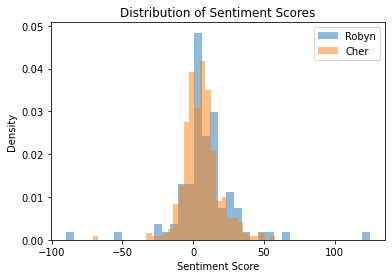

In [17]:
robyn_scores = first_artist_lyrics['sentiment_score']
cher_scores = second_artist_lyrics['sentiment_score']
# Plot the distributions
plt.hist(robyn_scores, bins='auto', density=True, alpha=0.5, 
         label='Robyn')
plt.hist(cher_scores, bins='auto', density=True, alpha=0.5, 
         label='Cher')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.title('Distribution of Sentiment Scores')
plt.legend()
plt.show()

## Sentiment Analysis on Twitter Descriptions

In this section, define two sets of emojis you designate as positive and negative. Make sure to have at least 10 emojis per set. You can learn about the most popular emojis on Twitter at [the emojitracker](https://emojitracker.com/). 

Associate your positive emojis with a score of +1, negative with -1. Score the average sentiment of your two artists based on the Twitter descriptions of their followers. The average sentiment can just be the total score divided by number of followers. You do not need to calculate sentiment on non-emoji content for this section.


### Q: Which positive emoji is the most popular for each artist? Which negative emoji? 


In [40]:
#create positive and negative sets with assigned scores
positive_emojis = {'😄': 1, '👍': 1, '❤️': 1, '😊': 1, '🌟': 1, '😎': 1, '🎉': 1, 
                   '🥰': 1, '👏': 1, '😍': 1, '🌈': 1, '✨': 1, '💖': 1}
negative_emojis = {'😔': -1, '👎': -1, '😞': -1, '😢': -1, '😒': -1, '🙁': -1, '😑': -1, 
                   '😠': -1, '😡': -1, '😣': -1, '😕': -1, '💔': -1, '😫': -1 }

#Score the average sentiment of your two artists based on the Twitter descriptions of their followers
artist_sentiment = {}
top_positive_emojis = {}
top_negative_emojis = {}

for artist, descriptions in twitter_data.groupby('artist')['description']:
    total_score = 0
    total_count = 0
    positive_counts = {}
    negative_counts = {}

    for description in descriptions:
        if isinstance(description, str): 
            for emoji in positive_emojis:
                if emoji in description:
                    positive_counts[emoji] = positive_counts.get(emoji, 0) + 1
                    total_score += positive_emojis[emoji]
                    total_count += 1

            for emoji in negative_emojis:
                if emoji in description:
                    negative_counts[emoji] = negative_counts.get(emoji, 0) + 1
                    total_score += negative_emojis[emoji]
                    total_count += 1
                    
    top_positive_emojis[artist] = sorted(positive_counts, 
                                         key=positive_counts.get, 
                                         reverse=True)[:3]
    top_negative_emojis[artist] = sorted(negative_counts, 
                                         key=negative_counts.get, 
                                         reverse=True)[:3]

    average_sentiment = total_score / total_count if total_count > 0 else 0
    artist_sentiment[artist] = average_sentiment
    print(f"Average sentiment score for {artist}: {average_sentiment}")

Average sentiment score for cher: 0.9517043983758477
Average sentiment score for robyn: 0.9724534895672731


### Q: Which positive emoji is the most popular for each artist? Which negative emoji? 


In [41]:
print("Top 3 most popular positive emojis:")
for artist, emojis in top_positive_emojis.items():
    print(f"{artist}: {emojis}")
print()
print("Top 3 most popular negative emojis:")
for artist, emojis in top_negative_emojis.items():
    print(f"{artist}: {emojis}")

Top 3 most popular positive emojis:
cher: ['🌈', '❤️', '✨']
robyn: ['🌈', '❤️', '✨']

Top 3 most popular negative emojis:
cher: ['💔', '😔', '😢']
robyn: ['💔', '😒', '😔']
